## This file puts all the steps into a complete workflow:

0. Data simulation
1. Dataset splitting
2. Model building
3. Loss
4. Optimizer
5. Training - Validating loop
6. Drawing Train and Val loss curves
7. Testing
8. Saving model (model.state_dict() only)
9. Loading model (model.state_dict() only)
10. Inference (prediction)

In [1]:
import torch
import numpy as np

print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

2.11.0.dev20251216+cu130
Device: cuda


In [2]:
########################
## 0. Data simulation ##
########################

#---- X -----
np.random.seed(24)
X = torch.tensor(
        np.random.uniform(low=1, high=11, size=(200, 1)),
        dtype=torch.float32,
        device=device
    ).sort(dim=0).values

torch.manual_seed(24)
X += torch.normal(mean=2.5, std=1, size=(200, 1), device=device) # Add variation

#---- y -----
np.random.seed(25)
y = torch.tensor(
        np.random.uniform(low=100, high=150, size=(200,)),
        dtype=torch.float32,
        device=device
    ).sort(dim=0).values

torch.manual_seed(25)
y += torch.normal(mean=10, std=1, size=(200,), device=device) # Add variation

In [3]:
##########################
## 1. Dataset splitting ##
##########################

train_len = int(0.7 * len(X)) # MUST be INTEGER
val_len = int(0.15 * len(X))
test_len = len(X) - (train_len + val_len)

from torch.utils.data import DataLoader, TensorDataset, random_split

full_dataset = TensorDataset(X, y)
train_split, val_split, test_split = random_split(dataset=full_dataset, lengths=[train_len, val_len, test_len])

train_set = DataLoader(train_split, batch_size=16, shuffle=True)
val_set = DataLoader(val_split, batch_size=16, shuffle=True)
test_set = DataLoader(test_split, batch_size=16, shuffle=True)

In [4]:
#######################
## 2. Model building ##
#######################

from torch import nn

class LinearRegressionModel(nn.Module):  
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1, bias=True) # bias=True by default
        '''
        nn.Linear: applies an affine linear transformation y = xAᵀ + b
        in_features: the number of input features (Our X has only 1 column, i.e 1D vector -> in_features = 1)
        out_features: the number of output features (Our y is also a 1D vector -> out_features = 1)
        '''
        # self.coefs = nn.Parameter(torch.randn(size=(1, ), requires_grad=True, dtype=torch.float32))
        # self.bias = nn.Parameter(torch.randn(size=(1, ), requires_grad=True, dtype=torch.float32))
        
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(X)
        # return self.coefs*X + self.bias
    
'''Call out a model as an instance of a class'''
torch.manual_seed(42)
model = LinearRegressionModel()
model.to(device)

print(f'\nParameters before training:\n{model.state_dict()}') # Parameters before training
# OrderedDict({'linear_layer.weight': tensor([[0.7645]], device='cuda:0'), 'linear_layer.bias': tensor([0.8300], device='cuda:0')})


Parameters before training:
OrderedDict({'linear_layer.weight': tensor([[0.7645]], device='cuda:0'), 'linear_layer.bias': tensor([0.8300], device='cuda:0')})


In [5]:
#############
## 3. Loss ##
#############

loss_fn = nn.MSELoss() # mean squared error

In [6]:
##################
## 4. Optimizer ##
##################

optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=11.6
)

In [7]:
###################################
## 5. Training - Validating loop ##
###################################

epochs = 10

train_loss_list, val_loss_list = [], []

for epoch in range(1, epochs+1, 1):
    # --- TRAINING ---
    _ = model.train() # Turn on training mode, enable gradient tracking
    for X_batch, y_batch in train_set:
        # (Standard training steps: forward, loss, zero_grad, backward, step)
        y_preds = model(X_batch).squeeze()
        loss = loss_fn(y_preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # --- VALIDATION (Every epoch) ---
    _ = model.eval() # 1. Set model to evaluation mode
    val_loss = 0
    with torch.inference_mode(): # 2. Turn off gradient tracking to save memory
        for X_val, y_val in val_set: # 3. Iterate through val_set
            val_preds = model(X_val).squeeze()
            # Accumulate loss to get an average for the whole set
            val_loss += loss_fn(val_preds, y_val).item()
    
    avg_val_loss = val_loss / len(val_set)
    
    train_loss_list.append(loss.item())
    val_loss_list.append(avg_val_loss)
    
    if epoch % 2 == 0:
        print("+"*50)
        print(f"Epoch: {epoch}")
        print(f"Train loss: {loss:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 2
Train loss: 338.6355
Validation loss: 404.5150
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 4
Train loss: 108.6674
Validation loss: 174.4145
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 6
Train loss: 94.9725
Validation loss: 40.6029
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 8
Train loss: 8.6370
Validation loss: 33.2744
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10
Train loss: 25.2029
Validation loss: 30.3460


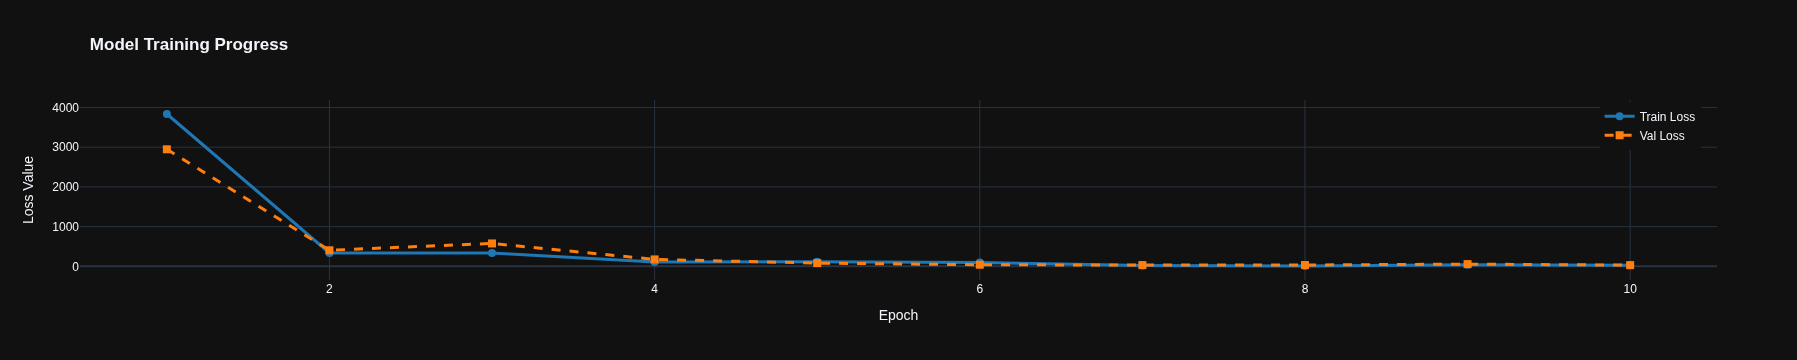

In [ ]:
##########################################
## 6. Drawing Train and Val loss curves ##
##########################################

def plot_train_val_loss_curves():
    import plotly.graph_objects as pgo
    import numpy as np
    
    # 1. Define the X-axis (epochs)
    epoch_axis = np.arange(1, epochs + 1, 1)

    fig = pgo.Figure()

    # 2. Add Training Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=train_loss_list,
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8)
    ))

    # 3. Add Validation Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=val_loss_list,
        mode='lines+markers',
        name='Val Loss',
        line=dict(color='#ff7f0e', width=3, dash='dash'),
        marker=dict(size=8, symbol='square')
    ))

    # 4. Layout & Styling
    fig.update_layout(
        title='<b>Model Training Progress</b>',
        xaxis_title='Epoch',
        yaxis_title='Loss Value',
        template='plotly_dark', # Clean dark background
        hovermode='x unified',   # Shows both values on hover
        legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
    )

    fig.show()
    
plot_train_val_loss_curves()

In [9]:
################
## 7. Testing ##
################

_ = model.eval()

test_loss = 0
with torch.inference_mode():
    for X_test, y_test in test_set: # Use the test_set loader
        test_preds = model(X_test)
        test_loss += loss_fn(test_preds, y_test.unsqueeze(1)).item()

print(f"Final Test Loss: {test_loss / len(test_set):.4f}")
# Final Test Loss: 24.9976

Final Test Loss: 24.9976


In [10]:
###############
## 8. Saving ##
###############

from pathlib import Path

MODEL_PATH = Path("02_General_Workflow").joinpath("save")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# PyTorch model can be saved in .pth or .pt format
PARAMS_NAME = "Altogether_StateDict.pth"

# Save the model (use model.state_dict() to save only the parameters)
torch.save(obj=model.state_dict(), f=MODEL_PATH.joinpath(PARAMS_NAME))

In [11]:
################
## 9. Loading ##
################

from pathlib import Path

MODEL_PATH = Path("02_General_Workflow").joinpath("save")
PARAMS_NAME = "Altogether_StateDict.pth"

# Create a new instance of the model class
loaded_model = LinearRegressionModel()
loaded_model.to(device)

loaded_model.load_state_dict(torch.load(MODEL_PATH.joinpath(PARAMS_NAME)))
# <All keys matched successfully>

<All keys matched successfully>

In [13]:
################################
## 10. Inference (prediction) ##
################################

'''Create new input'''
import numpy as np

torch.manual_seed(43)
X_new = torch.tensor(
    np.random.uniform(low=1, high=11, size=(5, 1)),
    dtype=torch.float32,
    device=device
)
    
print(X_new)
# tensor([[9.4897],
#         [4.1944],
#         [4.1960],
#         [3.6032],
#         [5.2499]], device='cuda:0')

'''Inference'''
_ = loaded_model.eval() # Turn off gradient tracking

with torch.inference_mode():
    y_inference = loaded_model(X_new)
    
print(y_inference)
# tensor([[136.7942],
#         [114.7179],
#         [114.7247],
#         [112.2534],
#         [119.1184]], device='cuda:0')

tensor([[9.9237],
        [5.7971],
        [4.4857],
        [7.8215],
        [2.6201]], device='cuda:0')
tensor([[138.6036],
        [121.3996],
        [115.9326],
        [129.8397],
        [108.1548]], device='cuda:0')
